Implementing 1D upwind scheme in vectorized form in numpy and tensorflow.
Demonstrate performance issue with np.roll and tf.manip.roll.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from numba import jit
import numpy as np

from advection_solver.util import roll

In [2]:
@jit(nopython=True)
def upwind_tendency_loop(c, u, dx, dt):
    '''
    Loop version of advection tendency with periodic boundary

    Args:
      c: 1d numpy array, density field
      u: 1d numpy array, wind field
      dx: float, grid spacing (assume uniform)
      dt: float, time step

    Returns:
      1d numpy array with same shape as `c`
    '''
    
    nx = c.size

    # re-stagger to C-grid, pointing from box[i-1] to box[i]
    # remove this step if input wind is already staggered
    # u = 0.5*(u+roll(u, 1))
    
    c_l = roll(c, 1)  # so c_l[i] == c[i-1], with periodic boundary
    
    flux = np.empty(nx)
    for i in range(nx):
        if u[i] > 0:
            flux[i] = u[i]*c_l[i]
        else:
            flux[i] = u[i]*c[i]
            
    tendency = flux - roll(flux, -1)
    
    return tendency*dt/dx

In [3]:
def upwind_tendency_vect(c, u, dx, dt):
    '''
    Vectorized version of advection tendency with periodic boundary

    Args:
      c: 1d numpy array, density field
      u: 1d numpy array, wind field
      dx: float, grid spacing (assume uniform)
      dt: float, time step

    Returns:
      1d numpy array with same shape as `c`
    '''

    # re-stagger to C-grid, pointing from box[i-1] to box[i]
    # remove this step if input wind is already staggered
    # u = 0.5*(u+np.roll(u, 1))

    c_l = np.roll(c, 1)  # so c_l[i] == c[i-1], with periodic boundary
            
    flux_right = np.maximum(u, 0) * c_l
    flux_left = np.minimum(u, 0) * c
    flux = flux_right + flux_left
            
    tendency = flux - np.roll(flux, -1)
    
    return tendency*dt/dx

In [4]:
nx = 100
Lx = 1
dx = Lx/nx
dt = 0.01
u = np.ones(nx) * -0.5
c0 = np.zeros(nx)
c0[int(nx*0.2):int(nx*0.4)] = 1.0

In [7]:
%%time
# run at least twice to jit-compile
nt = 10000

c1 = c0.copy()
for _ in range(nt):
    c1 += upwind_tendency_loop(c1, u, dx, dt)

CPU times: user 58 ms, sys: 3.26 ms, total: 61.3 ms
Wall time: 60.6 ms


In [8]:
%%time
nt = 10000

c2 = c0.copy()
for _ in range(nt):
    c2 += upwind_tendency_vect(c2, u, dx, dt)
    
# Almost 10x slower than numba! 

CPU times: user 365 ms, sys: 12.9 ms, total: 378 ms
Wall time: 369 ms


In [9]:
np.array_equal(c1, c2)

True

Text(0.5,1,'upwind scheme')

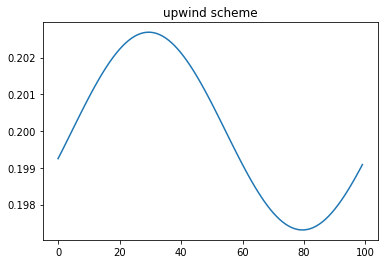

In [10]:
plt.plot(c1)
plt.title('upwind scheme')

## Fix the slowness of np.roll

In [11]:
def upwind_tendency_vect_numba_roll(c, u, dx, dt):
    '''
    Vectorized version of advection tendency with periodic boundary
    Use numba version of roll; other part still uses numpy vectorization

    Args:
      c: 1d numpy array, density field
      u: 1d numpy array, wind field
      dx: float, grid spacing (assume uniform)
      dt: float, time step

    Returns:
      1d numpy array with same shape as `c`
    '''

    # re-stagger to C-grid, pointing from box[i-1] to box[i]
    # remove this step if input wind is already staggered
    # u = 0.5*(u+np.roll(u, 1))

    c_l = roll(c, 1)  # so c_l[i] == c[i-1], with periodic boundary
            
    flux_right = np.maximum(u, 0) * c_l
    flux_left = np.minimum(u, 0) * c
    flux = flux_right + flux_left
            
    tendency = flux - roll(flux, -1)
    
    return tendency*dt/dx

In [13]:
%%time
# run at least twice to jit-compile
nt = 10000

c3 = c0.copy()
for _ in range(nt):
    c3 += upwind_tendency_vect_numba_roll(c3, u, dx, dt)
    
# 5x faster than original. Indeed np.roll is something to blame

CPU times: user 121 ms, sys: 2.65 ms, total: 124 ms
Wall time: 122 ms


In [14]:
np.array_equal(c1, c3)

True

In [15]:
# see if there's further speed-up by jit-ting the function body
upwind_tendency_vect_numba_roll_jit = jit(upwind_tendency_vect_numba_roll, nopython=True)

In [17]:
%%time
# run at least twice to jit-compile
nt = 10000

c4 = c0.copy()
for _ in range(nt):
    c4 += upwind_tendency_vect_numba_roll_jit(c4, u, dx, dt)
    
# 2x faster than before. Match pure numba version. Not sure due to the speed-up of which part.

CPU times: user 54.7 ms, sys: 1.95 ms, total: 56.6 ms
Wall time: 57.2 ms


In [18]:
np.array_equal(c1, c4)

True

# TF Eager

## Matrix multiplication benchmark against numpy

In [19]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

tfe.enable_eager_execution()

In [20]:
# numpy
A = np.random.rand(2000, 2000)
B = np.random.rand(2000, 2000)
%time C = np.matmul(A, B)

CPU times: user 329 ms, sys: 9.85 ms, total: 339 ms
Wall time: 177 ms


In [21]:
# TF eager
A_tensor = tf.convert_to_tensor(A)
B_tensor = tf.convert_to_tensor(B)

%time C_tensor = tf.matmul(A_tensor, B_tensor)

CPU times: user 1.24 s, sys: 41.1 ms, total: 1.28 s
Wall time: 345 ms


In [22]:
np.allclose(C, C_tensor.numpy(), rtol=1e-20, atol=1e-12), np.array_equal(C, C_tensor.numpy())

(True, False)

In [23]:
# TF graph
with tf.Graph().as_default():
    a = tf.random_normal((2000, 2000))
    b = tf.random_normal((2000, 2000))
    c = tf.matmul(a, b)
      
    with tf.Session() as sess:
        %time sess.run(c)

CPU times: user 739 ms, sys: 17.9 ms, total: 757 ms
Wall time: 231 ms


## Upwind in TF Eager

In [24]:
def upwind_tendency_tf(c, u, dx, dt):
    '''
    Tensorflow vectorized version of advection tendency with periodic boundary

    Args:
      c: 1d Tensor, density field
      u: 1d Tensor, wind field
      dx: 0d Tensor, grid spacing (assume uniform)
      dt: 0d Tensor, time step

    Returns:
      1d Tensor with same shape as `c`
    '''
    
    # re-stagger to C-grid, pointing from box[i-1] to box[i]
    # remove this step if input wind is already staggered
    # u = 0.5*(u+tf.manip.roll(u, 1, 0))

    c_l = tf.manip.roll(c, 1, 0)  # so c_l[i] == c[i-1], with periodic boundary
            
    flux_right = tf.maximum(u, 0) * c_l
    flux_left = tf.minimum(u, 0) * c
    flux = flux_right + flux_left
            
    tendency = flux - tf.manip.roll(flux, -1, 0)
    
    return tendency*dt/dx

In [25]:
u_tensor = tf.convert_to_tensor(u)

In [28]:
%%time
nt = 10000

c_tensor = tf.convert_to_tensor(c0)
for _ in range(nt):
    c_tensor += upwind_tendency_tf(c_tensor, u_tensor, dx, dt)
    
# ~4 slower numpy (with np.roll) and 50x slower than numba
# Probably due to tf.manip.roll()

# Q: not sure if that's the proper way of time marching. c_tensor will have an id > 100000 at the end of loop
# The "official" PDE example (https://www.tensorflow.org/tutorials/non-ml/pdes) updates Variable values, not creating new nodes.

CPU times: user 2.17 s, sys: 178 ms, total: 2.35 s
Wall time: 1.73 s


In [29]:
np.array_equal(c_tensor.numpy(), c1) 

True